In [ ]:
import os
import random
import math
import fnmatch
import datetime
import pickle
import cv2
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from imgaug import augmenters as img_aug

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import tensorflow as tf
import keras
from keras.models import Sequential
from keras import regularizers
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model

from PIL import Image
from natsort import natsorted

In [ ]:
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def get_image_data(data_path):
    file_list = natsorted(os.listdir(data_path))
    file_list = [x for x in file_list if '(' not in x] # remove duplicated images
    img_data = []
    img_id = []
    pattern = "*.png"
    for filename in file_list:
        if fnmatch.fnmatch(filename, pattern):
            img_data.append(os.path.join(data_path, filename))
            img_id.append(filename)
    return img_data, img_id

def get_steering_data(data_path):
    strg_df = pd.read_csv(data_path)
    strg_data = strg_df[['angle', 'speed']].to_numpy()                                                
    return strg_data

Image path:  /content/gdrive/My Drive/machine-learning-in-science-2021/train/training_data/661.png
Steering angle:  0.875
Steering speed:  1.0
                                          Image_Path   Angle  Speed
0  /content/gdrive/My Drive/machine-learning-in-s...  0.4375    0.0
1  /content/gdrive/My Drive/machine-learning-in-s...  0.8125    1.0
2  /content/gdrive/My Drive/machine-learning-in-s...  0.4375    1.0
3  /content/gdrive/My Drive/machine-learning-in-s...  0.6250    1.0
4  /content/gdrive/My Drive/machine-learning-in-s...  0.5000    0.0


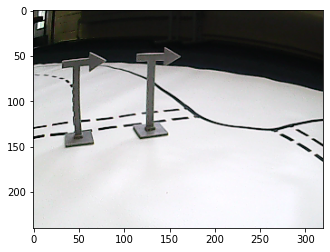

In [ ]:
# Import data

# train_img_data = '/content/gdrive/My Drive/machine-learning-in-science-2021/train/training_data'
# train_strg_data = '/content/gdrive/My Drive/machine-learning-in-science-2021/train/training_norm.csv'

train_img_data = '/content/gdrive/My Drive/machine-learning-in-science-2021/train/training_data'
train_img, img_id = get_image_data(train_img_data)

train_strg_data = '/content/gdrive/My Drive/machine-learning-in-science-2021/train/training_norm.csv'
train_strg = get_steering_data(train_strg_data)

image_index = 660
plt.imshow(Image.open(train_img[image_index]))
print("Image path: ", train_img[image_index])
print("Steering angle: ", train_strg[image_index][0])
print("Steering speed: ", train_strg[image_index][1])
df = pd.DataFrame()
df['Image_Path'] = train_img
df[['Angle', 'Speed']] = train_strg
print(df.head())

Text(0.5, 1.0, 'Speed distribution')

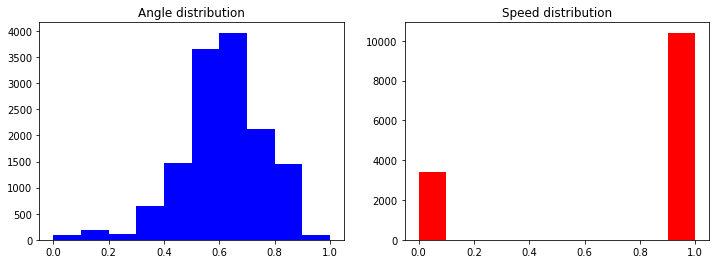

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(df['Angle'], color='blue')
axes[0].set_title('Angle distribution')
axes[1].hist(df['Speed'], color='red')
axes[1].set_title('Speed distribution')

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train_img, train_strg, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(x_train), len(x_val)))

Training data: 11034
Validation data: 2759


In [ ]:
# Data augmentation

def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
    return image

def image_augment(image):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    return image

Text(0.5, 1.0, 'processed')

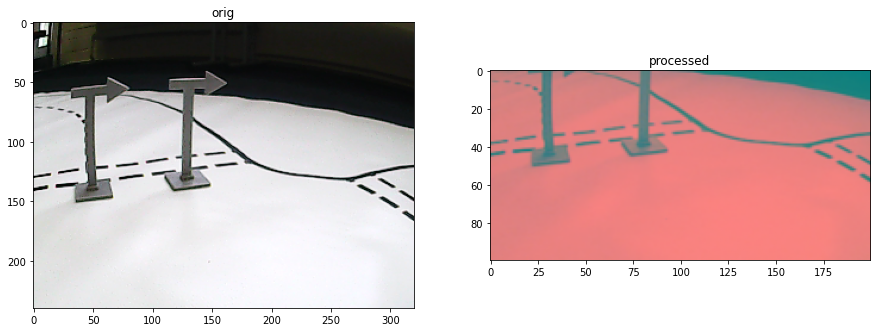

In [ ]:
# Preprocess data

def img_preprocess(image):
    height, length, _ = image.shape
    image = image[int(height/4):,:,:]  # remove top half of the image, as it is not relavant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,100))
    image = image / 255
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(train_img[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")

In [ ]:
# Create model

def self_driving_model():
    model = Sequential()

    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(100, 200, 3), activation='elu', use_bias=True)) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu', use_bias=True)) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu', use_bias=True)) 
    model.add(Conv2D(64, (3, 3), activation='elu', use_bias=True)) 
    #model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu', use_bias=True)) 
    
    # Fully Connected Layers
    model.add(Flatten())
    #model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu', use_bias=True))
    model.add(Dense(50, activation='elu', use_bias=True))
    model.add(Dense(10, activation='elu', use_bias=True))
    model.add(Dense(2, use_bias=True))

    model.compile(optimizer=Adam(lr=0.0001),loss='mse')
    return model

In [ ]:
model = self_driving_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 48, 98, 24)        1824      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 22, 47, 36)        21636     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 9, 22, 48)         43248     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 20, 64)         27712     
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 20, 64)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 5, 18, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 5760)             

In [ ]:
def img_data_gen(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_img = []
        batch_strg = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths)-1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering = steering_angles[random_index]
            if is_training:
                image = image_augment(image)

            image = img_preprocess(image)

            batch_img.append(image)
            batch_strg.append(steering)

        yield(np.asarray(batch_img), np.asarray(batch_strg))

In [ ]:
output_dir = '/content/gdrive/My Drive/machine-learning-in-science-2021'
callback_checkpoint = [keras.callbacks.EarlyStopping(patience=5),
                       keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'picar_check.h5'), verbose=1, save_best_only=True)]

In [ ]:
BATCH_SIZE = 32
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE))
steps_per_epoch = compute_steps_per_epoch(len(x_train))
val_steps = compute_steps_per_epoch(len(x_val))

history = model.fit(img_data_gen(x_train, y_train, BATCH_SIZE, True),
                    steps_per_epoch=steps_per_epoch,
                    epochs=50,
                    validation_data=img_data_gen(x_val, y_val, BATCH_SIZE, False),
                    validation_steps=val_steps,
                    verbose=1,
                    shuffle=1,
                    callbacks=[callback_checkpoint])

# always save model output as soon as model finishes training
model.save(os.path.join(output_dir,'picar_final.h5'))

date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
history_path = os.path.join(output_dir,'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

Epoch 1/50
345/345 [==============================] - 1082s 3s/step - loss: 0.1416 - val_loss: 0.0844

Epoch 00001: val_loss improved from inf to 0.08439, saving model to /content/gdrive/My Drive/machine-learning-in-science-2021/picar_check.h5
Epoch 2/50
345/345 [==============================] - 535s 2s/step - loss: 0.0934 - val_loss: 0.0628

Epoch 00002: val_loss improved from 0.08439 to 0.06279, saving model to /content/gdrive/My Drive/machine-learning-in-science-2021/picar_check.h5
Epoch 3/50
345/345 [==============================] - 351s 1s/step - loss: 0.0767 - val_loss: 0.0524

Epoch 00003: val_loss improved from 0.06279 to 0.05237, saving model to /content/gdrive/My Drive/machine-learning-in-science-2021/picar_check.h5
Epoch 4/50
345/345 [==============================] - 295s 857ms/step - loss: 0.0648 - val_loss: 0.0421

Epoch 00004: val_loss improved from 0.05237 to 0.04209, saving model to /content/gdrive/My Drive/machine-learning-in-science-2021/picar_check.h5
Epoch 5/50
3

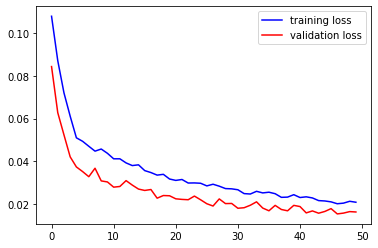

In [ ]:
history_path = os.path.join(output_dir,'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

In [ ]:
def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{output_dir}/picar_check.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

In [ ]:
X_test, y_test = next(img_data_gen(x_val, y_val, 500, False))

y_pred = predict_and_summarize(X_test, y_test)

mse       = 0.017
r_squared = 72.42%



In [ ]:
test_img_data = '/content/gdrive/My Drive/machine-learning-in-science-2021/test/test_data/test_data'
test_img, image_id = get_image_data(test_img_data)
img_id = pd.DataFrame(image_id, columns=['image_id']).replace({'.png':''}, regex=True)
model = load_model(f'{output_dir}/picar_check.h5')

In [ ]:
def test_data_read(image_paths):
    batch_img = []

    for i in range(len(image_paths)):
        image = my_imread(image_paths[i])
        image = img_preprocess(image)
        batch_img.append(image)
    return batch_img

test_image = test_data_read(test_img)
test_image = np.asarray(test_image).reshape(1020,100,200,3)

In [ ]:
predictions = model.predict(test_image)

In [ ]:
prediction = pd.DataFrame(predictions, columns=['angle', 'speed']).round({'speed': 0})
prediction['speed'] = prediction.speed.astype(int)
test_pred = pd.concat([img_id, prediction], axis=1).set_index('image_id')

In [ ]:
from google.colab import files

test_pred.to_csv('test_prediction.csv')
files.download('test_prediction.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>